# Summary of Analysis

## Data selection

I handpicked images with good qualities (frontal, light uniform background) from the image datasets for jerseys and shirts. There were 199 images for shirts and 220 images for jerseys.

## Analysis of 64 x 64 images

First, I shuffled the data and split them into 80% training set and 20% testing set. Then, I fit a StandardScaler on the training data and transformed them so that they have zero mean and unit variance. 

Applying a plain LinearSVC on both original and normalized training data, I got prediction accuracies at 0.88 and 0.90 for the test set. This shows that scaling does improve prediction accuracy for a plain SVC.

### PCA

I applied PCA with different numbers of components on both original and normalized data and plotted the prediction accuracies. The model performance curve first peaked at n=50 with normalized data (This peak is chosen over the later peaks for model parsimony). The accuracy curve for normalized data is mostly above the one for non-normalized data, indicating the importance of normalization for PCA analysis. The optimal prediction accuracy is around 0.93.

I also plotted the corresponding eigenvalues for the largest components. We can see that eigenvalues are very close to zero after n=50.

### LDA

I applied LDA on both original and normalized data, and the prediction accuracies were the same, reflecting that data normalization does not necessarily improve the results of LDA analysis. Optimal accuracy is around 0.82.

This poor accuracy reflects LDA's failure when the number of features exceeds the number of observations. Therefore, I decided to shrink the images to 20 x 20 B&W (dim=400) so that LDA could be more meaningful (I didn't shrink them even further because images smaller than 20 x 20 hardly reflect the features of shirts and jerseys).

It's also interesting to observe that in LDA, plain SVC and large-n PCA, there are obvious signs of overfitting (training accuracy is way higher than test accuracy). It's especially the case for LDA. This is probably because, in this analysis, the number of features far exceeds the number of observations.

## Analysis of 20 x 20 images

I repeated the analysis above on 20 x 20 black and white images (summing RGB values to a single value). Surprisingly, the performance of PCA and LDA did not improve (LDA did even worse); however, the plain SVC was able to achieve a test accuracy of 0.94 for normalized data.

## Visualizations

Lastly, out of curiosity, I plotted some images showing the eigencomponents of PCA, as well as the coefficients of LDA.

## Recommendation

In this analysis I found that PCA on 64 x 64 normalized image data performed equally well as plain SVC on 20 x 20 B&W normalized image data. However, I would recommend PCA as it is able to achieve dimension reduction by capturing major variances. This advantage might be more obvious when we apply it on larger images, since there are a lot of redundancy in the data (e.g. the background).

# Classifying 64x64 Images

In [1]:
# Rescale images
from PIL import Image
import glob, os

size = 64, 64

for clothes in ["shirt", "jersey"]:
    count = 0
    for infile in glob.glob("{}/*".format(clothes)):
        im = Image.open(infile)
        im = im.resize(size, Image.ANTIALIAS)
        im.save("rescaled_{}/".format(clothes) + "{}.JPEG".format(count), "JPEG")
        count += 1

In [19]:
# Load data
from PIL import Image
import glob, os
import numpy as np

def image_to_array(im):
    """
    Reference: https://stackoverflow.com/questions/13550376/pil-image-to-array-numpy-array-to-array-python
    """      
    im_arr = np.fromstring(im.tobytes(), dtype=np.uint8)
    try:
        im_arr = im_arr.reshape((im.size[1], im.size[0], 3))   
    except:
        #black and white
        im_arr = np.array([[x,x,x] for x in im_arr])
        im_arr = im_arr.reshape((im.size[1], im.size[0], 3)) 
    return im_arr

data = []
for infile in glob.glob("rescaled_shirt/*"):
    im = Image.open(infile)
    pixels = image_to_array(im)
    data.append((pixels,0))
for infile in glob.glob("rescaled_jersey/*"):
    im = Image.open(infile)
    pixels = image_to_array(im)
    data.append((pixels,1))

In [20]:
import random
random.shuffle(data)

In [21]:
X, y = zip(*data)

In [22]:
X = [_.ravel() for _ in X]

In [23]:
ratio = 0.8
cutoff = int(ratio*len(y))
X_train, X_test = X[:cutoff], X[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

In [24]:
# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Plain SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train, y_train)
print "Without Scaling"
print "train acc=", accuracy_score(y_train, model.predict(X_train))
print "test acc=", accuracy_score(y_test, model.predict(X_test))
print

model = LinearSVC()
model.fit(X_train_scaled, y_train)
print "With Scaling"
print "train acc=", accuracy_score(y_train, model.predict(X_train_scaled))
print "test acc=", accuracy_score(y_test, model.predict(X_test_scaled))

Without Scaling
train acc= 1.0
test acc= 0.880952380952

With Scaling
train acc= 1.0
test acc= 0.904761904762


In [30]:
# Fitting PCA
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
l1, l2, l3, l4 = [], [], [], []
n_comps = range(10,451,10)
for n_comp in n_comps:
    print n_comp,
    #Without Scaling
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit(X_train).transform(X_train)
    model_pca = LinearSVC()
    model_pca.fit(X_train_pca, y_train)
    temp = accuracy_score(y_train, model_pca.predict(X_train_pca))
    l1.append(temp)
    X_test_pca = pca.transform(X_test)
    temp = accuracy_score(y_test, model_pca.predict(X_test_pca))
    l2.append(temp)
    #With scaling
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit(X_train_scaled).transform(X_train_scaled)
    model_pca = LinearSVC()
    model_pca.fit(X_train_pca, y_train)
    temp = accuracy_score(y_train, model_pca.predict(X_train_pca))
    l3.append(temp)
    X_test_pca = pca.transform(X_test_scaled)
    temp = accuracy_score(y_test, model_pca.predict(X_test_pca))
    l4.append(temp)

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450


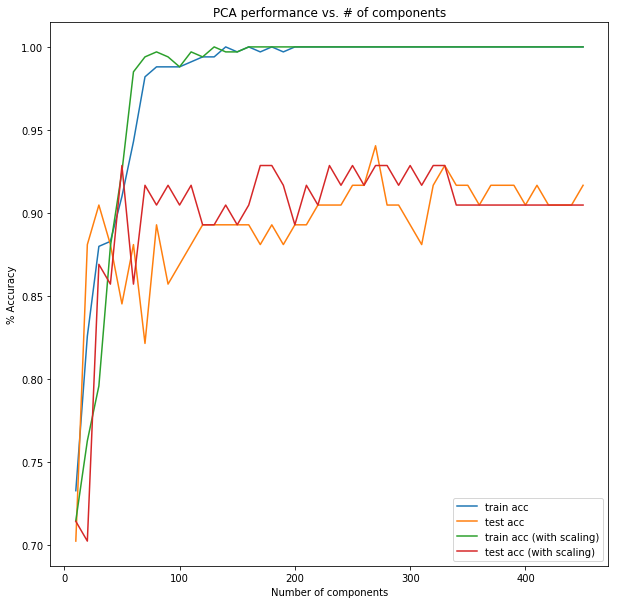

In [31]:
# Plot PCA accuracies with respect to the number of components
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(n_comps, l1, label="train acc")
plt.plot(n_comps, l2, label="test acc")
plt.plot(n_comps, l3, label="train acc (with scaling)")
plt.plot(n_comps, l4, label="test acc (with scaling)")
plt.title("PCA performance vs. # of components")
plt.xlabel("Number of components")
plt.ylabel("% Accuracy")
plt.legend()
plt.show()

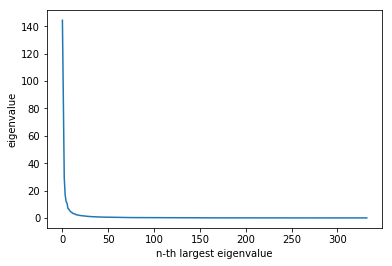

In [88]:
# Plot eigenvalues
pca = PCA()
pca.fit(X_train_scaled)
plt.plot(pca.explained_variance_)
plt.xlabel('n-th largest eigenvalue')
plt.ylabel('eigenvalue')
plt.show()

In [34]:
# Fitting LDA
print "Without Scaling"
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit(X_train, y_train).transform(X_train)
model_lda = LinearSVC()
model_lda.fit(X_train_lda, y_train)
temp = accuracy_score(y_train, model_lda.predict(X_train_lda))
print "train acc=", temp
X_test_lda = lda.transform(X_test)
temp = accuracy_score(y_test, model_lda.predict(X_test_lda))
print "test acc=", temp


print "With Scaling"
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit(X_train_scaled, y_train).transform(X_train_scaled)
model_lda = LinearSVC()
model_lda.fit(X_train_lda, y_train)
temp = accuracy_score(y_train, model_lda.predict(X_train_lda))
print "train acc=", temp
X_test_lda = lda.transform(X_test_scaled)
temp = accuracy_score(y_test, model_lda.predict(X_test_lda))
print "test acc=", temp

Without Scaling
train acc= 0.990990990991
test acc= 0.821428571429
With Scaling
train acc= 0.990990990991
test acc= 0.821428571429


# Classifying 20 x 20 Images

In [36]:
# Rescale images to 20*20
from PIL import Image
import glob, os

size = 20, 20

for clothes in ["shirt", "jersey"]:
    count = 0
    for infile in glob.glob("{}/*".format(clothes)):
        im = Image.open(infile)
        im = im.resize(size, Image.ANTIALIAS)
        im.save("rescaled20_{}/".format(clothes) + "{}.JPEG".format(count), "JPEG")
        count += 1

In [75]:
# Load data
from PIL import Image
import glob, os
import numpy as np

data = []
for infile in glob.glob("rescaled20_shirt/*"):
    im = Image.open(infile)
    pixels = image_to_array(im)
    data.append((pixels,0))
for infile in glob.glob("rescaled20_jersey/*"):
    im = Image.open(infile)
    pixels = image_to_array(im)
    data.append((pixels,1))

In [76]:
import random
random.shuffle(data)

In [77]:
X, y = zip(*data)

In [78]:
# Superimpose RGB values
X = [_.sum(axis=2) for _ in X]

In [79]:
X = [_.ravel() for _ in X]

In [80]:
ratio = 0.8
cutoff = int(ratio*len(y))
X_train, X_test = X[:cutoff], X[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

In [81]:
# Normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
# Plain SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train, y_train)
print "Without Scaling"
print "train acc=", accuracy_score(y_train, model.predict(X_train))
print "test acc=", accuracy_score(y_test, model.predict(X_test))
print

model = LinearSVC()
model.fit(X_train_scaled, y_train)
print "With Scaling"
print "train acc=", accuracy_score(y_train, model.predict(X_train_scaled))
print "test acc=", accuracy_score(y_test, model.predict(X_test_scaled))

Without Scaling
train acc= 1.0
test acc= 0.928571428571

With Scaling
train acc= 1.0
test acc= 0.940476190476


In [84]:
# Fitting PCA
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
l1, l2, l3, l4 = [], [], [], []
n_comps = range(5,201,5)
for n_comp in n_comps:
    print n_comp,
    #Without Scaling
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit(X_train).transform(X_train)
    model_pca = LinearSVC()
    model_pca.fit(X_train_pca, y_train)
    temp = accuracy_score(y_train, model_pca.predict(X_train_pca))
    l1.append(temp)
    X_test_pca = pca.transform(X_test)
    temp = accuracy_score(y_test, model_pca.predict(X_test_pca))
    l2.append(temp)
    #With scaling
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit(X_train_scaled).transform(X_train_scaled)
    model_pca = LinearSVC()
    model_pca.fit(X_train_pca, y_train)
    temp = accuracy_score(y_train, model_pca.predict(X_train_pca))
    l3.append(temp)
    X_test_pca = pca.transform(X_test_scaled)
    temp = accuracy_score(y_test, model_pca.predict(X_test_pca))
    l4.append(temp)

 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200


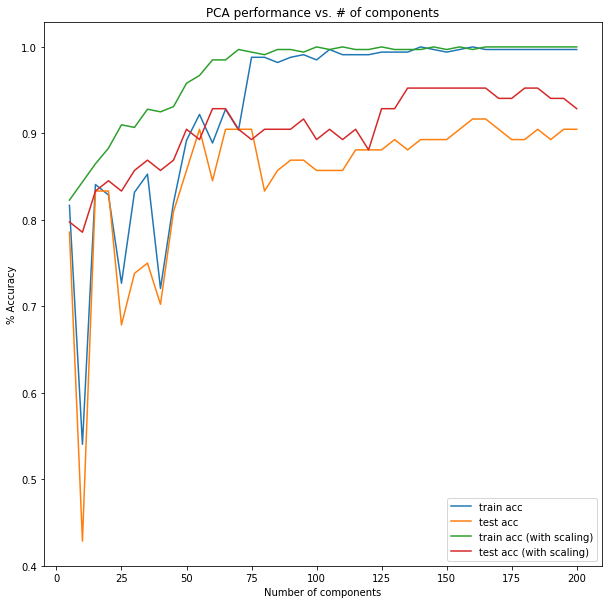

In [85]:
# Plot PCA accuracies with respect to the number of components
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(n_comps, l1, label="train acc")
plt.plot(n_comps, l2, label="test acc")
plt.plot(n_comps, l3, label="train acc (with scaling)")
plt.plot(n_comps, l4, label="test acc (with scaling)")
plt.title("PCA performance vs. # of components")
plt.xlabel("Number of components")
plt.ylabel("% Accuracy")
plt.legend()
plt.show()

In [86]:
# Fitting LDA
print "Without Scaling"
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit(X_train, y_train).transform(X_train)
model_lda = LinearSVC()
model_lda.fit(X_train_lda, y_train)
temp = accuracy_score(y_train, model_lda.predict(X_train_lda))
l3.append(temp)
print "train acc=", temp
X_test_lda = lda.transform(X_test)
temp = accuracy_score(y_test, model_lda.predict(X_test_lda))
l4.append(temp)
print "test acc=", temp


print "With Scaling"
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit(X_train_scaled, y_train).transform(X_train_scaled)
model_lda = LinearSVC()
model_lda.fit(X_train_lda, y_train)
temp = accuracy_score(y_train, model_lda.predict(X_train_lda))
l3.append(temp)
print "train acc=", temp
X_test_lda = lda.transform(X_test_scaled)
temp = accuracy_score(y_test, model_lda.predict(X_test_lda))
l4.append(temp)
print "test acc=", temp

Without Scaling
train acc= 1.0
test acc= 0.761904761905
With Scaling
train acc= 1.0
test acc= 0.761904761905


# Visualizations

In [47]:
# Load data
from PIL import Image
import glob, os
import numpy as np

def image_to_array(im):
    """
    Loads JPEG image into 3D Numpy array of shape 
    (width, height, channels)
    """      
    im_arr = np.fromstring(im.tobytes(), dtype=np.uint8)
    try:
        im_arr = im_arr.reshape((im.size[1], im.size[0], 3))   
    except:
        #black and white
        im_arr = np.array([[x,x,x] for x in im_arr])
        im_arr = im_arr.reshape((im.size[1], im.size[0], 3)) 
    return im_arr

data = []
for infile in glob.glob("rescaled_shirt/*"):
    im = Image.open(infile)
    pixels = image_to_array(im)
    data.append((pixels,0))
for infile in glob.glob("rescaled_jersey/*"):
    im = Image.open(infile)
    pixels = image_to_array(im)
    data.append((pixels,1))

In [48]:
import random
random.shuffle(data)

In [49]:
X, y = zip(*data)

In [50]:
X = [_.ravel() for _ in X]

## PCA Eigentops

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
pca = PCA()
pca.fit(X_scaled)

### Visualizing the first five eigencomponents of PCA.

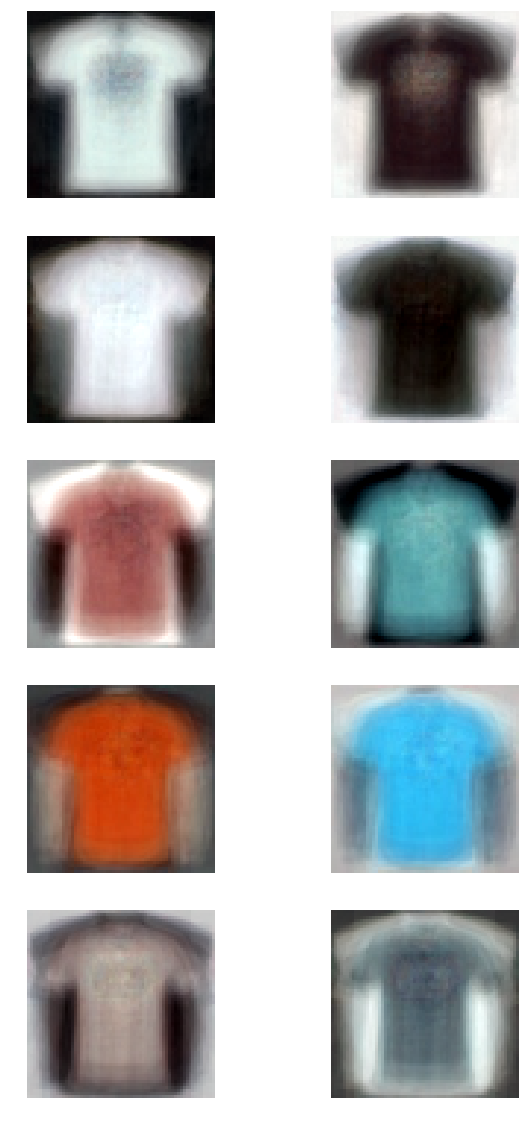

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
vfunc = np.vectorize(lambda x: max(min(255,x), 0))
for i in range(5):
    c = pca.components_[i]
    lowest = (c-min(c))*pca.singular_values_[i]*12
    highest = 255-lowest
    highest = vfunc(highest)
    lowest = vfunc(lowest)
    lowest.shape = (64,64,3)
    highest.shape = (64,64,3)
    im = Image.fromarray(np.uint8(lowest))
    plt.subplot(5,2, i*2+1)
    plt.imshow(im)
    plt.axis("off")
    im = Image.fromarray(np.uint8(highest))
    plt.subplot(5,2, i*2+2)
    plt.imshow(im)
    plt.axis("off")

### Visualizing the reconstructed shirts and jerseys using only 50 principal components.

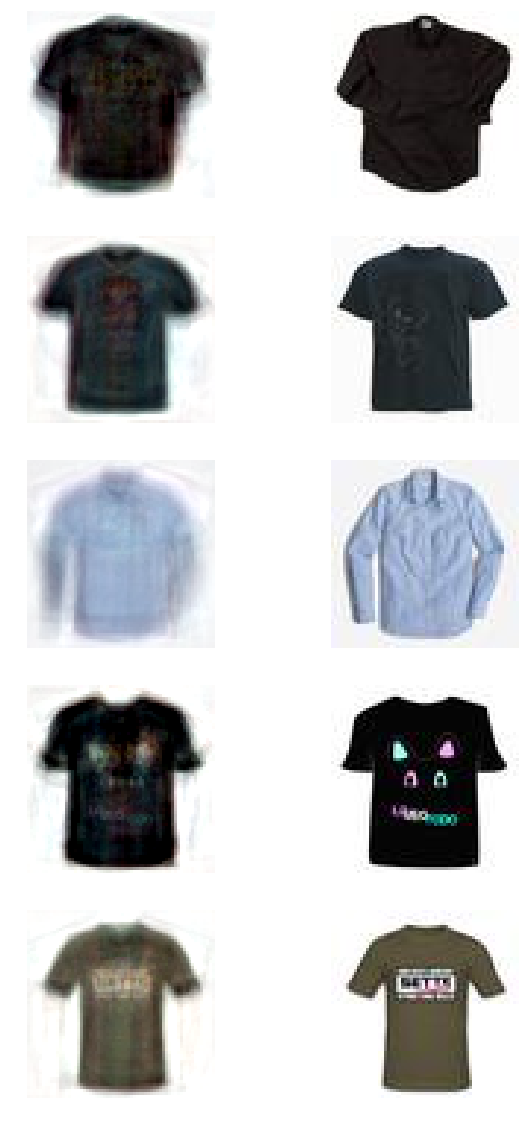

In [55]:
from sklearn.preprocessing import normalize
plt.figure(figsize=(10,20))
X_pca = pca.transform(X_scaled)
for i in range(5):
    c = pca.components_
    r = np.random.random(len(c))
    max_ = X_pca.max(axis=0)
    min_ = X_pca.min(axis=0)
    arr = X_pca[i][:50]#r*(max_-min_)*0.6+min_+0.2*(max_-min_)
    arr = np.concatenate([arr, [0]*(len(c)-len(arr))])
    arr = pca.inverse_transform(arr)
    arr = scaler.inverse_transform(arr)
    vfunc = np.vectorize(lambda x: max(min(255,x), 0))
    arr = vfunc(arr)
    arr.shape = (64,64,3)
    im = Image.fromarray(np.uint8(arr))
    plt.subplot(5,2, i*2+1)
    plt.imshow(im)
    plt.axis("off")
    
    arr = X[i]
    arr.shape = (64,64,3)
    im = Image.fromarray(np.uint8(arr))
    plt.subplot(5,2, i*2+2)
    plt.imshow(im)
    plt.axis("off")
    

## LDA Visuals

In [57]:
X = [_.ravel() for _ in X]

In [58]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

### The average shirt and the average jersey.

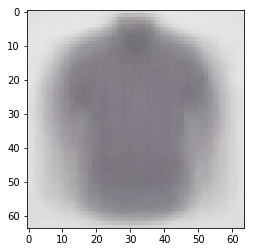

In [59]:
im = Image.fromarray(np.uint8(lda.means_[0].reshape(64,64,3)))
plt.imshow(im)

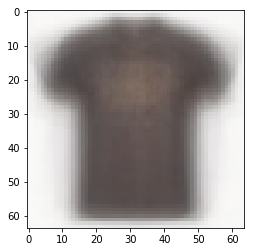

In [60]:
im = Image.fromarray(np.uint8(lda.means_[1].reshape(64,64,3)))
plt.imshow(im)

### Major pixels that distinguish shirts and jerseys.

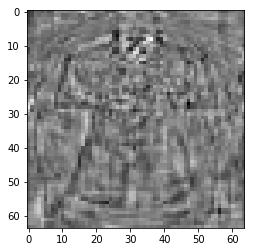

In [72]:
c = lda.coef_.reshape(64,64,3)
c = c.sum(axis=2)
plt.imshow(c, cmap="gray")